In [1]:
import numpy as np
import sklearn.datasets

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

In [2]:
d = 2 # dimensions
k = 3 # number of classes
n = 200 
data_colors = np.array(["blue", "red", "green", "yellow", "black", "white"])[:k]

In [3]:
def plot(x, y=None, a=None):
    if y is None:
        c = None
    else:
        c = data_colors[y]
    
    if a is not None:
        x0, x1 = np.meshgrid(
            np.linspace(np.min(x[:, 0]) - 1, np.max(x[:, 0]) + 1, 500).reshape(-1, 1),
            np.linspace(np.min(x[:, 1]) - 1, np.max(x[:, 1]) + 1, 500).reshape(-1, 1)
        )
        
        custom_cmap = ListedColormap(c)
        X_new = np.c_[x0.ravel(), x1.ravel()]
        Xp = np.empty((X_new.shape[0], d + 1))
        Xp[:, :d] = X_new
        Xp[:, d] = 1.
        zz = (Xp @ a.T).argmax(axis=-1).reshape(x0.shape)
        plt.contourf(x0, x1, zz)
    
    plt.scatter(x[:, 0], x[:, 1], c=c)
    
    axes = plt.gca()
    axes.set_xlim([np.min(x[:, 0]) - 1, np.max(x[:, 0]) + 1])
    axes.set_ylim([np.min(x[:, 1]) - 1, np.max(x[:, 1]) + 1])
    
    plt.show()

In [4]:
def accuracy(gold, predicted):
    return (gold == predicted).mean()

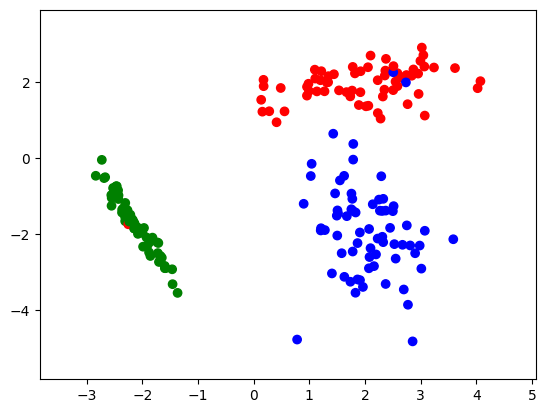

In [5]:
X_no_bias, Y = sklearn.datasets.make_classification(
    n_samples=n,
    n_features=d,
    n_classes=k,
    n_informative=d,
    n_redundant=0,
    n_repeated=0,
    n_clusters_per_class=1,
    class_sep=2 # default=1
)

X = np.empty((n, d + 1))
X[:, :d] = X_no_bias
X[:, d] = 1.

plot(X, Y)

## Multiclass hinge loss

### Proposed loss:

We suppose $y \in \{0, .., k - 1\}$, $a \in R^{k,d}$

$$
\ell(y, f(x)) = \left [ 1 - (f_{y}(x) - \min_{j} f_{j}(x)) + \sum_{i \neq y} (f_{i}(x) - \min_{j} f_{j}(x)) \right ]_{+}
$$

we substract the minimum to make sure the scores are not negative. Then the gold class score has to be at least greater than the sum of the other scores + 1.

### Optimization using sub-gradient descent

$$
\nabla_{a_{l}} \ell(y, f(x)) = 
    \begin{cases}
    0 & \text{if} \quad \ell(y, f(x)) = 0\\
    - 1_{l = argmin_{j} f_{j}(x)} \times (k - 2) \times x \quad - \quad (2 \times 1_{y = l} - 1) \times x & \text{otherwise.}
    \end{cases}
$$

Tested for number of classes = 3, = 4

Accuracy at the last epoch:  0.975
Objective at the last epoch:  23.17119864585248
[[ 1.12448351 -0.9003394  -0.5795302 ]
 [ 0.90734777 -0.02945843 -0.38387629]
 [ 0.21525142 -0.60000053  0.09860224]]

Objective function:


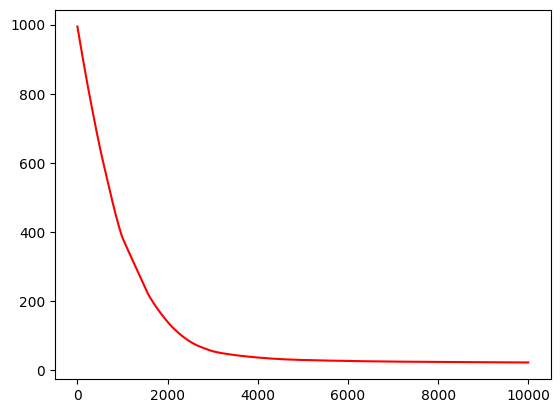

Classification accuracy:


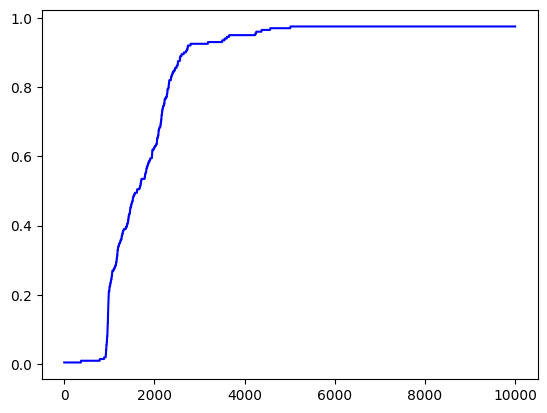

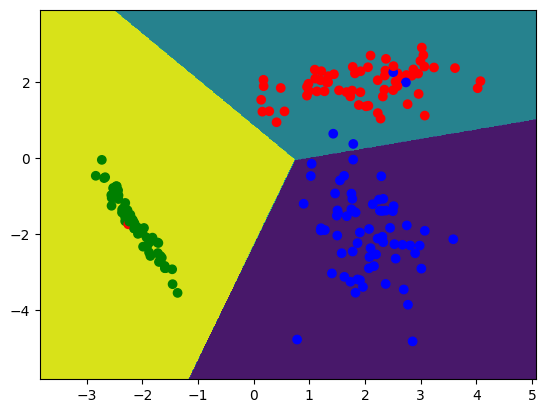

In [6]:
step_size = 1e-6
regularization_weight = 1
n_epochs = 10000

a = np.random.randn(k, d + 1)

objective_per_epoch = list()

accuracy_per_epoch = list()

for _ in range(n_epochs):

    scores = X @ a.T # n x k
    
    argmin_scores = scores.argmin(axis=-1)
    
    # substracting the minimum so that every score is positive
    scores = scores - scores.min(axis=1)[:, np.newaxis]
    
    hinge_sub_sum = - scores.sum(axis=1) + 2 * scores[np.arange(n), Y]
    
    # calculating the hinge loss
    hinge = np.maximum(0, 1 - hinge_sub_sum).sum()
    
    # regularization
    regularization = regularization_weight * (np.linalg.norm(a, axis=0) ** 2).sum() / 2
    
    obj = hinge + regularization
    objective_per_epoch.append(obj)
    
    
    # calculating sub-gradient
    # n x k x d : for each x, repeat it k times
    hinge_sub_gradient = np.repeat(X, k, axis=-1).reshape(n, d + 1, k).transpose((0, 2, 1))
    
    # for each row (0..n-1) of shape k x d: change the sign of the update corresponding to the golden class
    hinge_sub_gradient[np.arange(n), Y] = - hinge_sub_gradient[np.arange(n), Y]
    
    # calculating the sub-gradient for the min_{j} f_{j}(x)
    min_correction = np.zeros((n, k, d + 1))

    min_correction[np.arange(n), argmin_scores] = \
        np.repeat(X, k, axis=-1).reshape(n, d + 1, k).transpose((0, 2, 1))[np.arange(n), argmin_scores]
    
    hinge_sub_gradient = hinge_sub_gradient - (k - 2) * min_correction
    
    hinge_sub_gradient[1 - hinge_sub_sum < 0] = 0 

    hinge_sub_gradient = hinge_sub_gradient.sum(axis=0)
    
    # regularization sub-gradient
    regularization_sub_gradient = regularization_weight * a

    sub_gradient = hinge_sub_gradient + regularization_sub_gradient
    
    a -= step_size * sub_gradient
    
    accuracy_per_epoch.append(accuracy(Y, (X @ a.T).argmax(axis=-1)))

print("Accuracy at the last epoch: ", accuracy_per_epoch[-1])
print("Objective at the last epoch: ", objective_per_epoch[-1])
print(a)
print()

print("Objective function:")
plt.plot(objective_per_epoch, color="red")
plt.show()


print("Classification accuracy:")
plt.plot(accuracy_per_epoch, color="blue")
plt.show()

plot(X, Y, a)

For 4 classes, it becomes hard to separate them linearly.